# Fitting transit light curves of "spotless" transits

Open short cadence light curves, measure maximum flux for smoothed light curves of each quarter. 

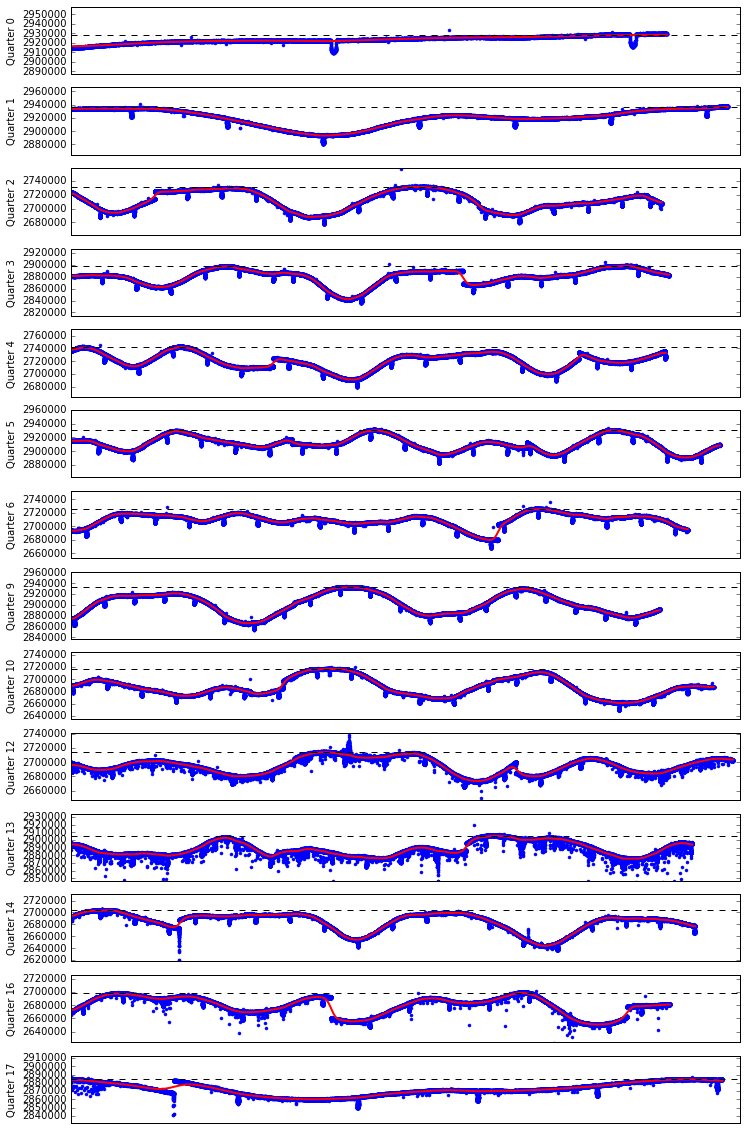

In [5]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import os
from glob import glob
import sys
sys.path.insert(0, '../')
from copy import deepcopy

from starspots.lightcurve import LightCurve
from starspots.systemparams import hat11_params_morris, aRs_i
from starspots.fitting import (print_emcee_results, run_emcee, 
                               plot_triangle, run_emcee_ephemeris)

from IPython.display import display_latex, Latex
import numpy as np
import matplotlib.pyplot as plt

# Here are initial orbit parameters for the first fits
hat11_params_init = hat11_params_morris()

# Here are parameters to fill with the results from the first fit, to
# use in the ephemeris fit
hat11_params_for_eph = hat11_params_morris()

path_to_fits_files = '/local/tmp/hat11/'

# Retrieve long and short cadence data
short_cadence_paths = glob(os.path.join(path_to_fits_files, 
                                        '*slc.fits'))

short_lc = LightCurve.from_raw_fits(short_cadence_paths, 
                                    name='raw_short', 
                                    transit_params=hat11_params_init)

data_path = '/astro/users/bmmorris/git/hat-11/lightcurves'

available_quarters = short_lc.get_available_quarters()
quarters = [short_lc.get_quarter(q) for q in short_lc.get_available_quarters()]

from scipy.ndimage import gaussian_filter

fig, ax = plt.subplots(14, 1, figsize=(12, 20))
quarterly_maxes = {}
set_upper_limit = 4e8
for i, quarter_number, lc in zip(range(len(available_quarters)), available_quarters, quarters):
    fluxes = lc.fluxes[lc.fluxes < set_upper_limit]
    smoothed_fluxes = gaussian_filter(fluxes, sigma=700)
    quarterly_maxes[quarter_number] = np.max(smoothed_fluxes)

    ax[i].plot(fluxes, '.')
    ax[i].plot(smoothed_fluxes, 'r', lw=2)
    ax[i].axhline(np.max(smoothed_fluxes), ls='--', color='k')
    ax[i].set(ylabel='Quarter {0}'.format(quarter_number), 
              ylim=[0.99*smoothed_fluxes.min(), 1.01*smoothed_fluxes.max()],
              xticks=[])
plt.show()

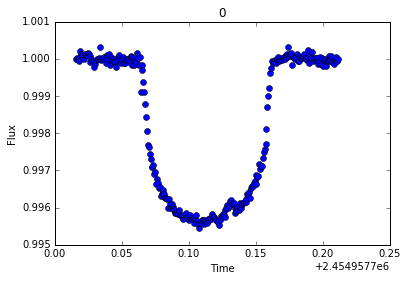

In [9]:
short_cadence = LightCurve(name='transits_short', 
                           **short_lc.mask_out_of_transit())
transits = short_cadence.get_transit_light_curves()
# Remove data if there aren't enough fluxes
transits = [transit for transit in transits if len(transit.times) > 250]
    
for transit in transits: 
    transit.subtract_polynomial_baseline(order=2)
    transit.fluxes += quarterly_maxes[transit.quarters[0]]
    transit.fluxes /= quarterly_maxes[transit.quarters[0]]
    transit.errors /= quarterly_maxes[transit.quarters[0]]

transits[0].plot()

### Identify "spotless" transits

* do rough model fit to each transit with `scipy.optimize.fmin` including only a few transit parameters ($R_p/R_s$, $a/R_s$, $i$, $t_0$)
* Measure $\chi^2$ for best-fit model
 
**Hypothesis**: $\chi^2$ can be used as a proxy for inverse starspot-importance in each transit. Transits with low $\chi^2$ are well-described by a simple transit model, which implies they have few spot crossings. 

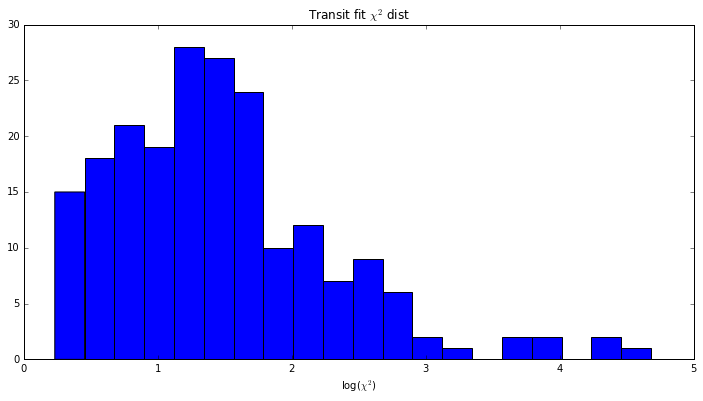

In [10]:
# Warning: this step fits each transit in the short cadence data and is slow (~few min)
chi2 = []
depths = []
for transit in transits:
    p, chi = transit.fiducial_transit_fit()
    depths.append(p[0])
    chi2.append(chi)
    
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()


### Choose "spotless" light curves

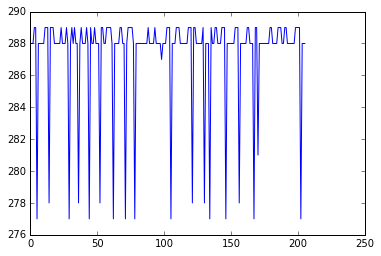

In [11]:
plt.plot([len(t.times) for t in transits])

# spotless transits: 10


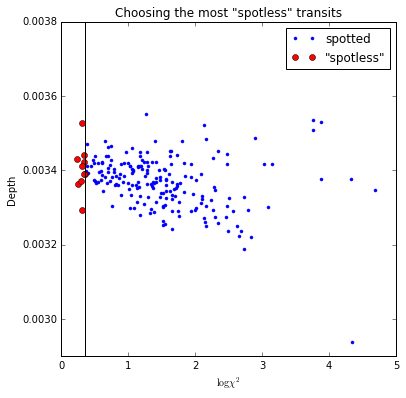

In [18]:
#chi2_threshold = 6.1
#depth_threshold = 0.003513

chi2_threshold = 0.36#2.45#3.45#6.7
depth_threshold = 0.0038
from starspots.lightcurve import concatenate_transit_light_curves
spotless_transit_inds = ((np.log(chi2) < chi2_threshold) * 
                         (np.array(depths) < depth_threshold))
spotless_transits = concatenate_transit_light_curves([transit 
                                                      for i, transit in enumerate(transits) 
                                                      if spotless_transit_inds[i]], 
                                                     name='spotless_transits')
spotless_transits.save_to(data_path, overwrite=True)

print('# spotless transits: {}'
      .format(np.count_nonzero(spotless_transit_inds)))

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.log(chi2), depths, '.', label='spotted')
ax.plot(np.log(chi2)[spotless_transit_inds], 
        np.array(depths)[spotless_transit_inds], 'ro', label='"spotless"')

ax.axvline(chi2_threshold, color='k')
ax.axhline(depth_threshold, color='k')
ax.legend(loc='upper right')
ax.set(xlabel=r'$\log{\chi^2}$', ylabel=r'Depth', 
       title='Choosing the most "spotless" transits');

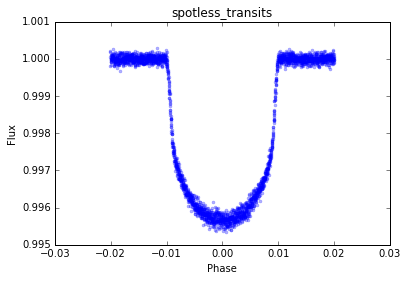

In [19]:
spotless_transits.plot(phase=True, plot_kwargs={'marker':'.', 'lw':0, 'alpha':0.3})

These are the "spotless" transits that we'll fit for transit parameters:

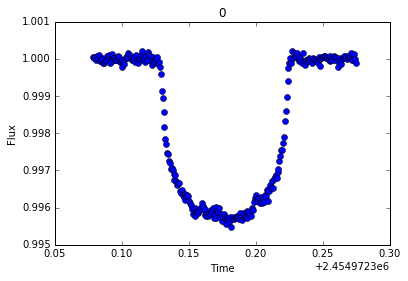

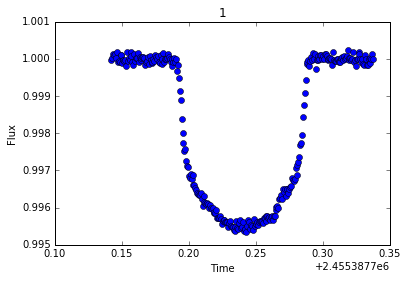

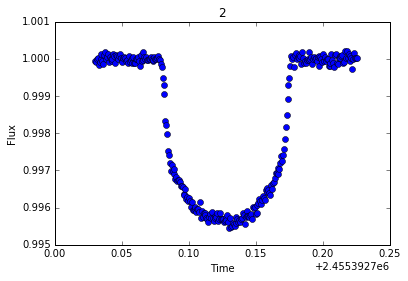

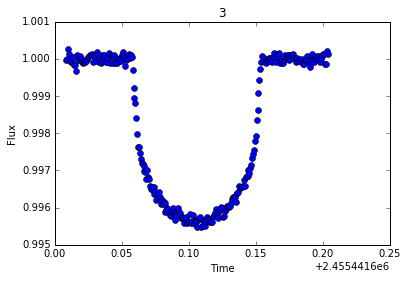

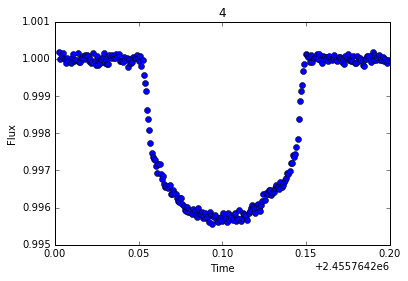

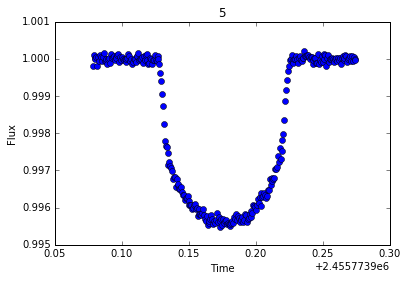

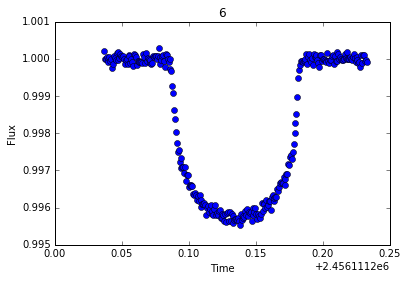

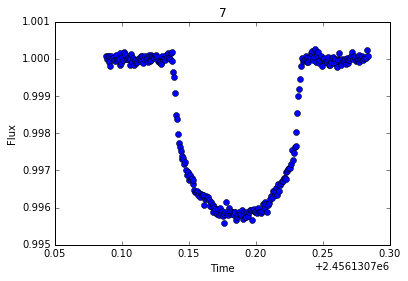

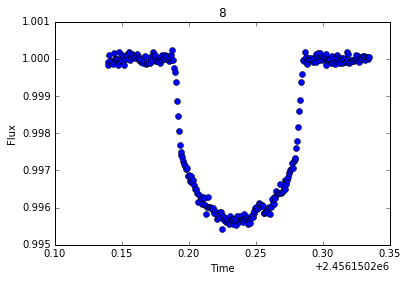

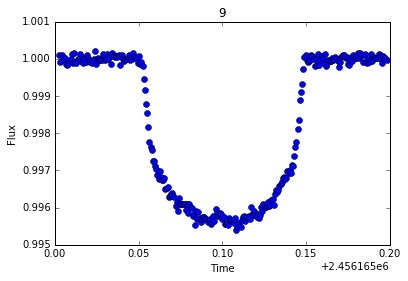

In [20]:
each_spotless_transit = spotless_transits.get_transit_light_curves()

for sptlstr in each_spotless_transit:
    sptlstr.plot()

In [21]:
print("Mean times of three 'spotless' transits: {0}"
      .format([t.times.jd.mean() for t in each_spotless_transit]))

Mean times of three 'spotless' transits: [2454972.4767144839, 2455387.9398802784, 2455392.8277162495, 2455441.7059998428, 2455764.3006615224, 2455774.0763001568, 2456111.3346321499, 2456130.8857470411, 2456150.4370310223, 2456165.1003556466]


### Get preliminary fits for $t_0$, $\delta$, $T_{14}$, $b$, $q_1$, $q_2$

accept frac = 0.42


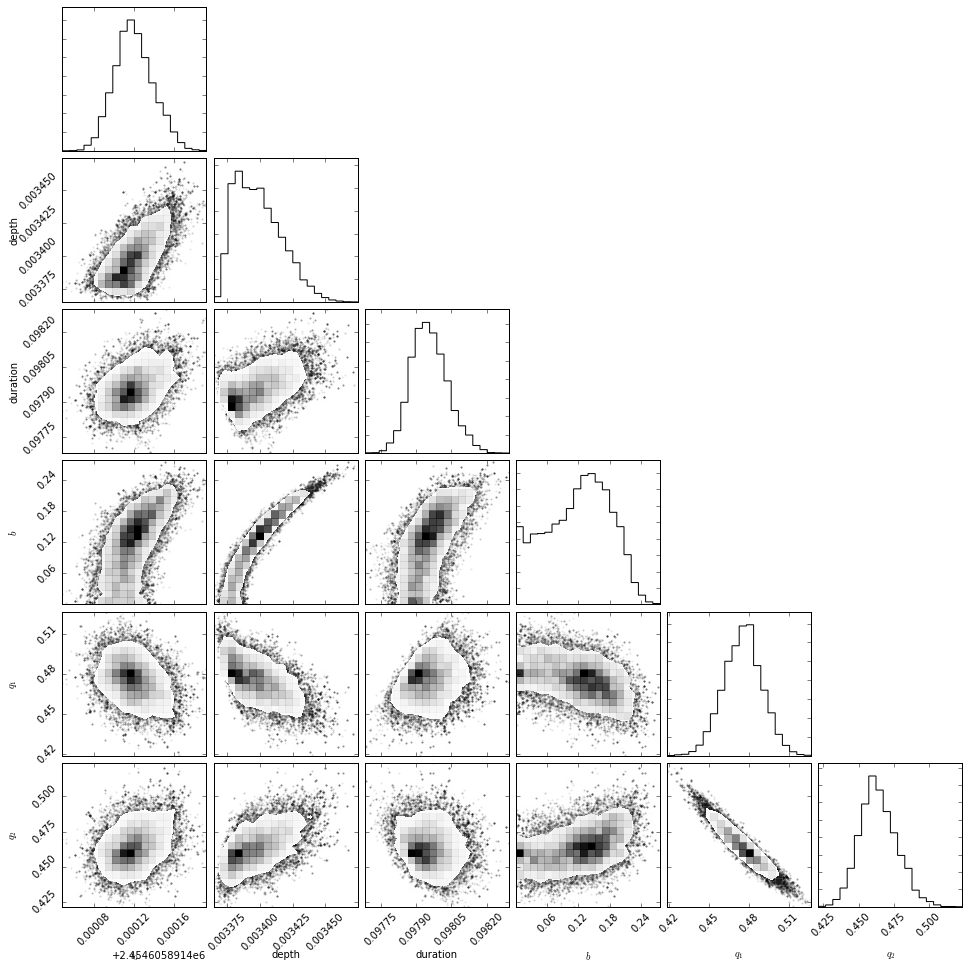

<IPython.core.display.Latex object>

In [23]:
def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

q1, q2 = kipping_to_quadratic(hat11_params_init.u)
[t0, depth, dur, b, q1, q2] = [hat11_params_init.t0, hat11_params_init.rp**2, 
                               hat11_params_init.duration, hat11_params_init.b,
                               q1, q2]
p0 = [t0, depth, dur, b, q1, q2]
n_steps = 1500
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples, sampler = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                             transit_lc.errors, n_steps, hat11_params_init)
print("accept frac = {0:.2f}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples[:, :])

#print_emcee_results(samples)
Latex(print_emcee_results(samples))

### With those preliminary fit params, fit for ephemeris

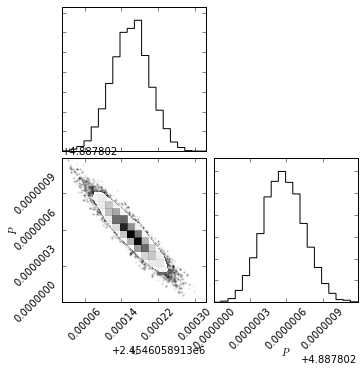

In [24]:
t0, depth, dur, b, q1, q2 = np.median(samples[:, :], axis=0)

hat11_params_for_eph.t0 = t0
hat11_params_for_eph.rp = depth**0.5
hat11_params_for_eph.duration = dur
hat11_params_for_eph.b = b
hat11_params_for_eph.u = kipping_to_quadratic([q1, q2])
ars, inc = aRs_i(hat11_params_for_eph)
hat11_params_for_eph.a = ars
hat11_params_for_eph.inc = inc

p0 = [hat11_params_for_eph.t0, hat11_params_for_eph.per]

n_steps = 1800
samples_eph, sampler_eph = run_emcee_ephemeris(p0, spotless_transits.times.jd, 
                                               spotless_transits.fluxes, 
                                               spotless_transits.errors, 
                                               n_steps, hat11_params_for_eph, 
                                               n_walkers=20)
plot_triangle(samples_eph)

In [25]:
for i, p in enumerate(['mid-transit time', 'period']):
    mid, minus, plus = np.percentile(samples_eph[:,i], [50, 16, 84])
    print("{3}: {0:.8f} +{1:.8f} -{2:.8f}".format(mid, plus-mid, mid-minus, p))

mid-transit time: 2454605.89146081 +0.00003954 -0.00004235
period: 4.88780257 +0.00000018 -0.00000016


### With new period measurement, fit the spotless transits again. These are the final posteriors.

accept frac = 0.427185714286


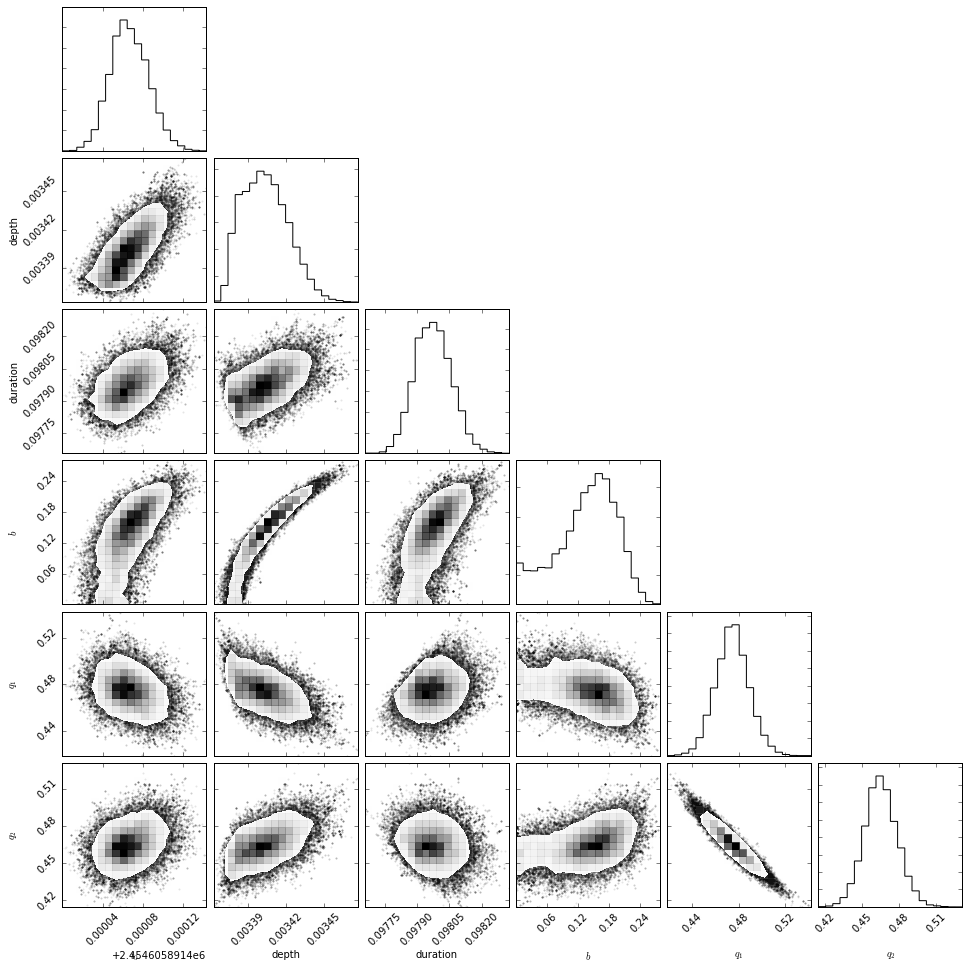

<IPython.core.display.Latex object>

In [26]:
hat11_params_from_eph = deepcopy(hat11_params_for_eph)
t0, per = np.percentile(samples_eph[:, :], 50, axis=0)

hat11_params_from_eph.t0 = t0
hat11_params_from_eph.per = per

def quadratic_to_kipping(p):
    u1, u2 = p
    q1 = (u1 + u2)**2
    q2 = 0.5*u1/(u1 + u2)
    return q1, q2

q1, q2 = quadratic_to_kipping(hat11_params_from_eph.u)

p0 = [hat11_params_from_eph.t0, hat11_params_from_eph.rp**2,
      hat11_params_from_eph.duration, hat11_params_from_eph.b,
      q1, q2]

n_steps = 2000
# n_steps=1000 Takes about ~3 min
samples_refined, sampler_refined = run_emcee(p0, spotless_transits.times.jd, 
                                             spotless_transits.fluxes, 
                                             spotless_transits.errors, 
                                             n_steps, hat11_params_from_eph,
                                             n_walkers=70)
print("accept frac = {0}".format(np.mean(sampler_refined.acceptance_fraction)))
plot_triangle(samples_refined[:, :])
Latex(print_emcee_results(samples_refined))

### Final Parameters

In [40]:
# final parameters: 
t0, depth, dur, b, q1, q2 = np.median(samples_refined[:, :], axis=0)

hat11_params_final = deepcopy(hat11_params_from_eph)
hat11_params_final.t0 = t0
hat11_params_final.rp = depth**0.5
hat11_params_final.duration = dur
hat11_params_final.b = b
hat11_params_final.u = list(kipping_to_quadratic([q1, q2]))
ars, inc = aRs_i(hat11_params_final)
hat11_params_final.a = ars
hat11_params_final.inc = inc

attrs = [attr for attr in dir(hat11_params_final) if '__' not in attr]

planet_properties = dict()
for attr in attrs:
    planet_properties[attr] = getattr(hat11_params_final, attr)

# Write to json:
import json
with open('hat11_parameters.json', 'w') as j:
    j.write(json.dumps(planet_properties, indent=4))

overall reduced chi2 = 1.55821754548


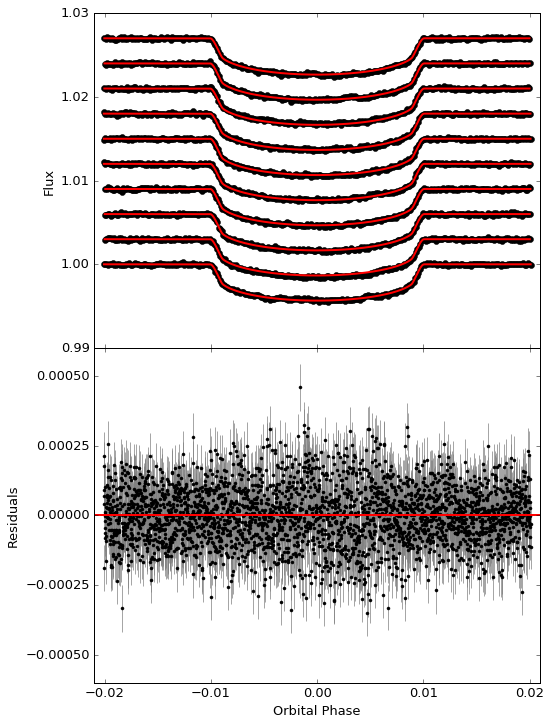

In [34]:
from starspots.lightcurve import generate_very_simple_model_lc_short as transit_model

fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex='col', sharey='row')

def jd_to_phase(jd_array):
    phase = ((jd_array - hat11_params_final.t0) % 
             hat11_params_final.per / hat11_params_final.per)
    phase[phase > 0.5] -= 1
    return phase

plt.rc('font', size=13)
transit_chi2 = []
n_fluxes = []
for i, transit in enumerate(each_spotless_transit):
    t_min = transit.times.jd.min()
    t_max = transit.times.jd.max()
    
    model_times = np.linspace(t_min, t_max, 3000)
    model_phase = jd_to_phase(model_times)
    transitmodel_fine = transit_model(model_times, 
                                      hat11_params_final, 
                                      hat11_params_final.rp**2)
    transitmodel = transit_model(transit.times.jd, 
                                 hat11_params_final, 
                                 hat11_params_final.rp**2)
    
    phase = jd_to_phase(transit.times.jd)
    
    offset_factor = 0.003*i
    ax[0].plot(phase,  transit.fluxes + offset_factor, 'ko')

    ax[0].plot(model_phase, transitmodel_fine + offset_factor, 'r', lw=2)

    ax[1].errorbar(phase, 
                   transit.fluxes - transitmodel, 
                   transit.errors,
                   fmt=',', color='gray', capsize=0, ecolor='gray', alpha=0.7)
    
    ax[1].plot(phase, transit.fluxes - transitmodel, 
              '.', color='k')
    
    transit_chi2.append(np.sum((transit.fluxes - transitmodel)**2 / 
                           transit.errors**2))
    n_fluxes.append(len(transit.fluxes))
total_chi2 = np.sum(transit_chi2)/(np.sum(n_fluxes) - 6)
print("overall reduced chi2 = {0}".format(total_chi2))

ax[1].set_xlabel('Orbital Phase')    
ax[1].axhline(0, ls='-', color='r', lw=2)
ax[0].set_ylabel('Flux')
ax[1].set_ylabel('Residuals')

# Set tick labels
ax[1].set_yticks(np.arange(-0.0005, 0.00075, 0.00025))
ax[0].set_yticks(np.arange(0.99, 1.03, 0.01))

fig.subplots_adjust(hspace=0)
#fig.subplots_adjust(hspace=spacing, wspace=spacing)
#fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
ax[0].set_xlim(phase.min()-0.001, phase.max()+0.001)
fig.savefig(os.path.join(dropbox_path, "figures", "hat11_spotless_transits_compact.png"), 
            bbox_inches='tight', dpi=500)
plt.show()

In [37]:
period_mid, period_minus, period_plus = np.percentile(samples_eph[:,1], [50, 16, 84])
period_upper = period_plus-period_mid
period_lower = period_plus-period_mid
best_fit_period = mid
Latex("$P: {{{0:.8f}}}^{{+{1:.8f}}}_{{-{2:.8f}}}$"
      .format(period_mid, period_plus-period_mid, period_mid-period_minus))

<IPython.core.display.Latex object>

## Create LaTeX table for paper

In [38]:
mid, minus, plus = np.percentile(samples_refined, [50, 16, 84], axis=0)
lower = mid - minus
upper = plus - mid

best_parameter_dict = {'t0': (mid[0], lower[0], upper[0]), 
                       'depth': (mid[1], lower[1], upper[1]), 
                       'duration': (mid[2], lower[2], upper[2]), 
                       'b': (mid[3], lower[3], upper[3]), 
                       'q1': (mid[4], lower[4], upper[4]), 
                       'q2': (mid[5], lower[5], upper[5]), 
                       'P': (period_mid, period_lower, period_upper)}

table_lines = ['$P$ [days] & ${{{0:.7f}}}^{{-{1:.7f}}}_{{+{2:.7f}}}$ \\\\',
                '$T_0$  [BJD] &  ${{{0}}}_{{-{1:0.6f}}}^{{+{2:0.6f}}}$ \\\\',
                '$T_{{14}}$ [days] &  ${{{0:.04f}}}_{{-{1:.04f}}}^{{+{2:.04f}}}$ \\\\',
                '$(R_p / R_s)^2$  &  ${{{0:.5f}}}_{{-{1:.5f}}}^{{+{2:.5f}}}$ \\\\',
                '$b$  &  ${{{0:.03f}}}_{{-{1:.03f}}}^{{+{2:.03f}}} $ \\\\',
                '$q_1$  & ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\',
                '$q_2$  &  ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\']
table_lines_order = ['P', 't0', 'duration', 'depth', 'b', 'q1', 'q2']
table_contents = ""

for line, param_i in zip(table_lines, table_lines_order):
    table_contents += line.format(*best_parameter_dict[param_i]) + '\n'

dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
with open(os.path.join(dropbox_path, 'results', 'kepler-17_light_curve_params.txt'), 'w') as param_table:
    param_table.write(table_contents)

In [39]:
def quadratic_to_nonlinear(u1, u2):
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

best_fit_nonlinear = quadratic_to_nonlinear(*hat11_params_final.u)
print("Non-linear parameters (algebraic trans): {0}".format(best_fit_nonlinear))
print("Best-fit quadratic parameters: {0:.5f}, {1:.5f}".format(*hat11_params_final.u))

Non-linear parameters (algebraic trans): (0, 0.73715064978836953, 0, -0.048367274306482549)
Best-fit quadratic parameters: 0.64042, 0.04837
